In [1]:
# ! pip3 install xgboost
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics, datasets, linear_model
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,mean_squared_error,r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from xgboost import XGBClassifier

In [2]:
from sklearn.metrics import confusion_matrix
def plot_cm(classifier, predictions):
    cm = confusion_matrix(y_test, predictions)
    
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap='RdBu')
    classNames = ['Noise', 'Incident']
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TP','FP'], ['FN', 'TN']]
    
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), 
                     horizontalalignment='center', color='White')
    
    plt.show()
        
    tp, fp, fn, tn = cm.ravel()

    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    F1 = 2*recall*precision/(recall+precision)

    print('Recall={0:0.3f}'.format(recall),'\nPrecision={0:0.3f}'.format(precision))
    print('F1={0:0.3f}'.format(F1))

In [21]:
week1 = pd.read_csv("week1.csv")
week2 = pd.read_csv("week2.csv")

full_data = week1.append(week2).drop(['Unnamed: 0', 'POLLER_TIME', 'MEASURED_VALUE', 'NEW_BUS_ID','SITE','HOUR','WEEKDAY'], axis = 1)

In [22]:
full_data_PctFree = full_data[full_data['PctFree_VALUE'].notnull()].dropna(axis = 1)
full_data_PctFree

,HAS_NEIGHBOR_INCIDENT,PctFree_VALUE,HOUR,WEEKDAY
106,False,14.33,7,2
107,False,14.33,7,2
108,False,14.33,7,2
109,False,14.33,7,2
110,False,14.33,7,2
...,...,...,...,...
1200463,False,10.39,4,1
1200465,False,5.15,17,2
1200466,False,13.22,1,3
1200467,False,11.05,1,3


In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    full_data_PctFree[full_data_PctFree.columns.difference(['HAS_NEIGHBOR_INCIDENT'])], full_data_PctFree['HAS_NEIGHBOR_INCIDENT'], test_size=0.2)


In [38]:
noise_ratio = y_train.value_counts()[0]/y_train.value_counts()[1]
y_train.value_counts()[1]/y_train.value_counts()[0]
optimized_GBM = XGBClassifier(
                             n_estimators=100, 
                             max_depth=5,
                             criterion = 'entropy',
                             reg_alpha = 100,
                             scale_pos_weight = noise_ratio)
optimized_GBM.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, criterion='entropy',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints=None, learning_rate=0.300000012,
              max_delta_step=0, max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, objective='binary:logistic', random_state=0,
              reg_alpha=100, reg_lambda=1, scale_pos_weight=305.715651135006,
              subsample=1, tree_method=None, validate_parameters=False,
              verbosity=None)

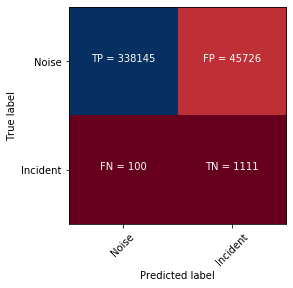

Recall=1.000 
Precision=0.881
F1=0.937


In [39]:
#Make predictions
y_pred = optimized_GBM.predict(X_test)
try:
    scores = optimized_GBM.decision_function(X_test)
except:
    scores = optimized_GBM.predict_proba(X_test)[:,1]
#Make plots
plot_cm(optimized_GBM, y_pred)

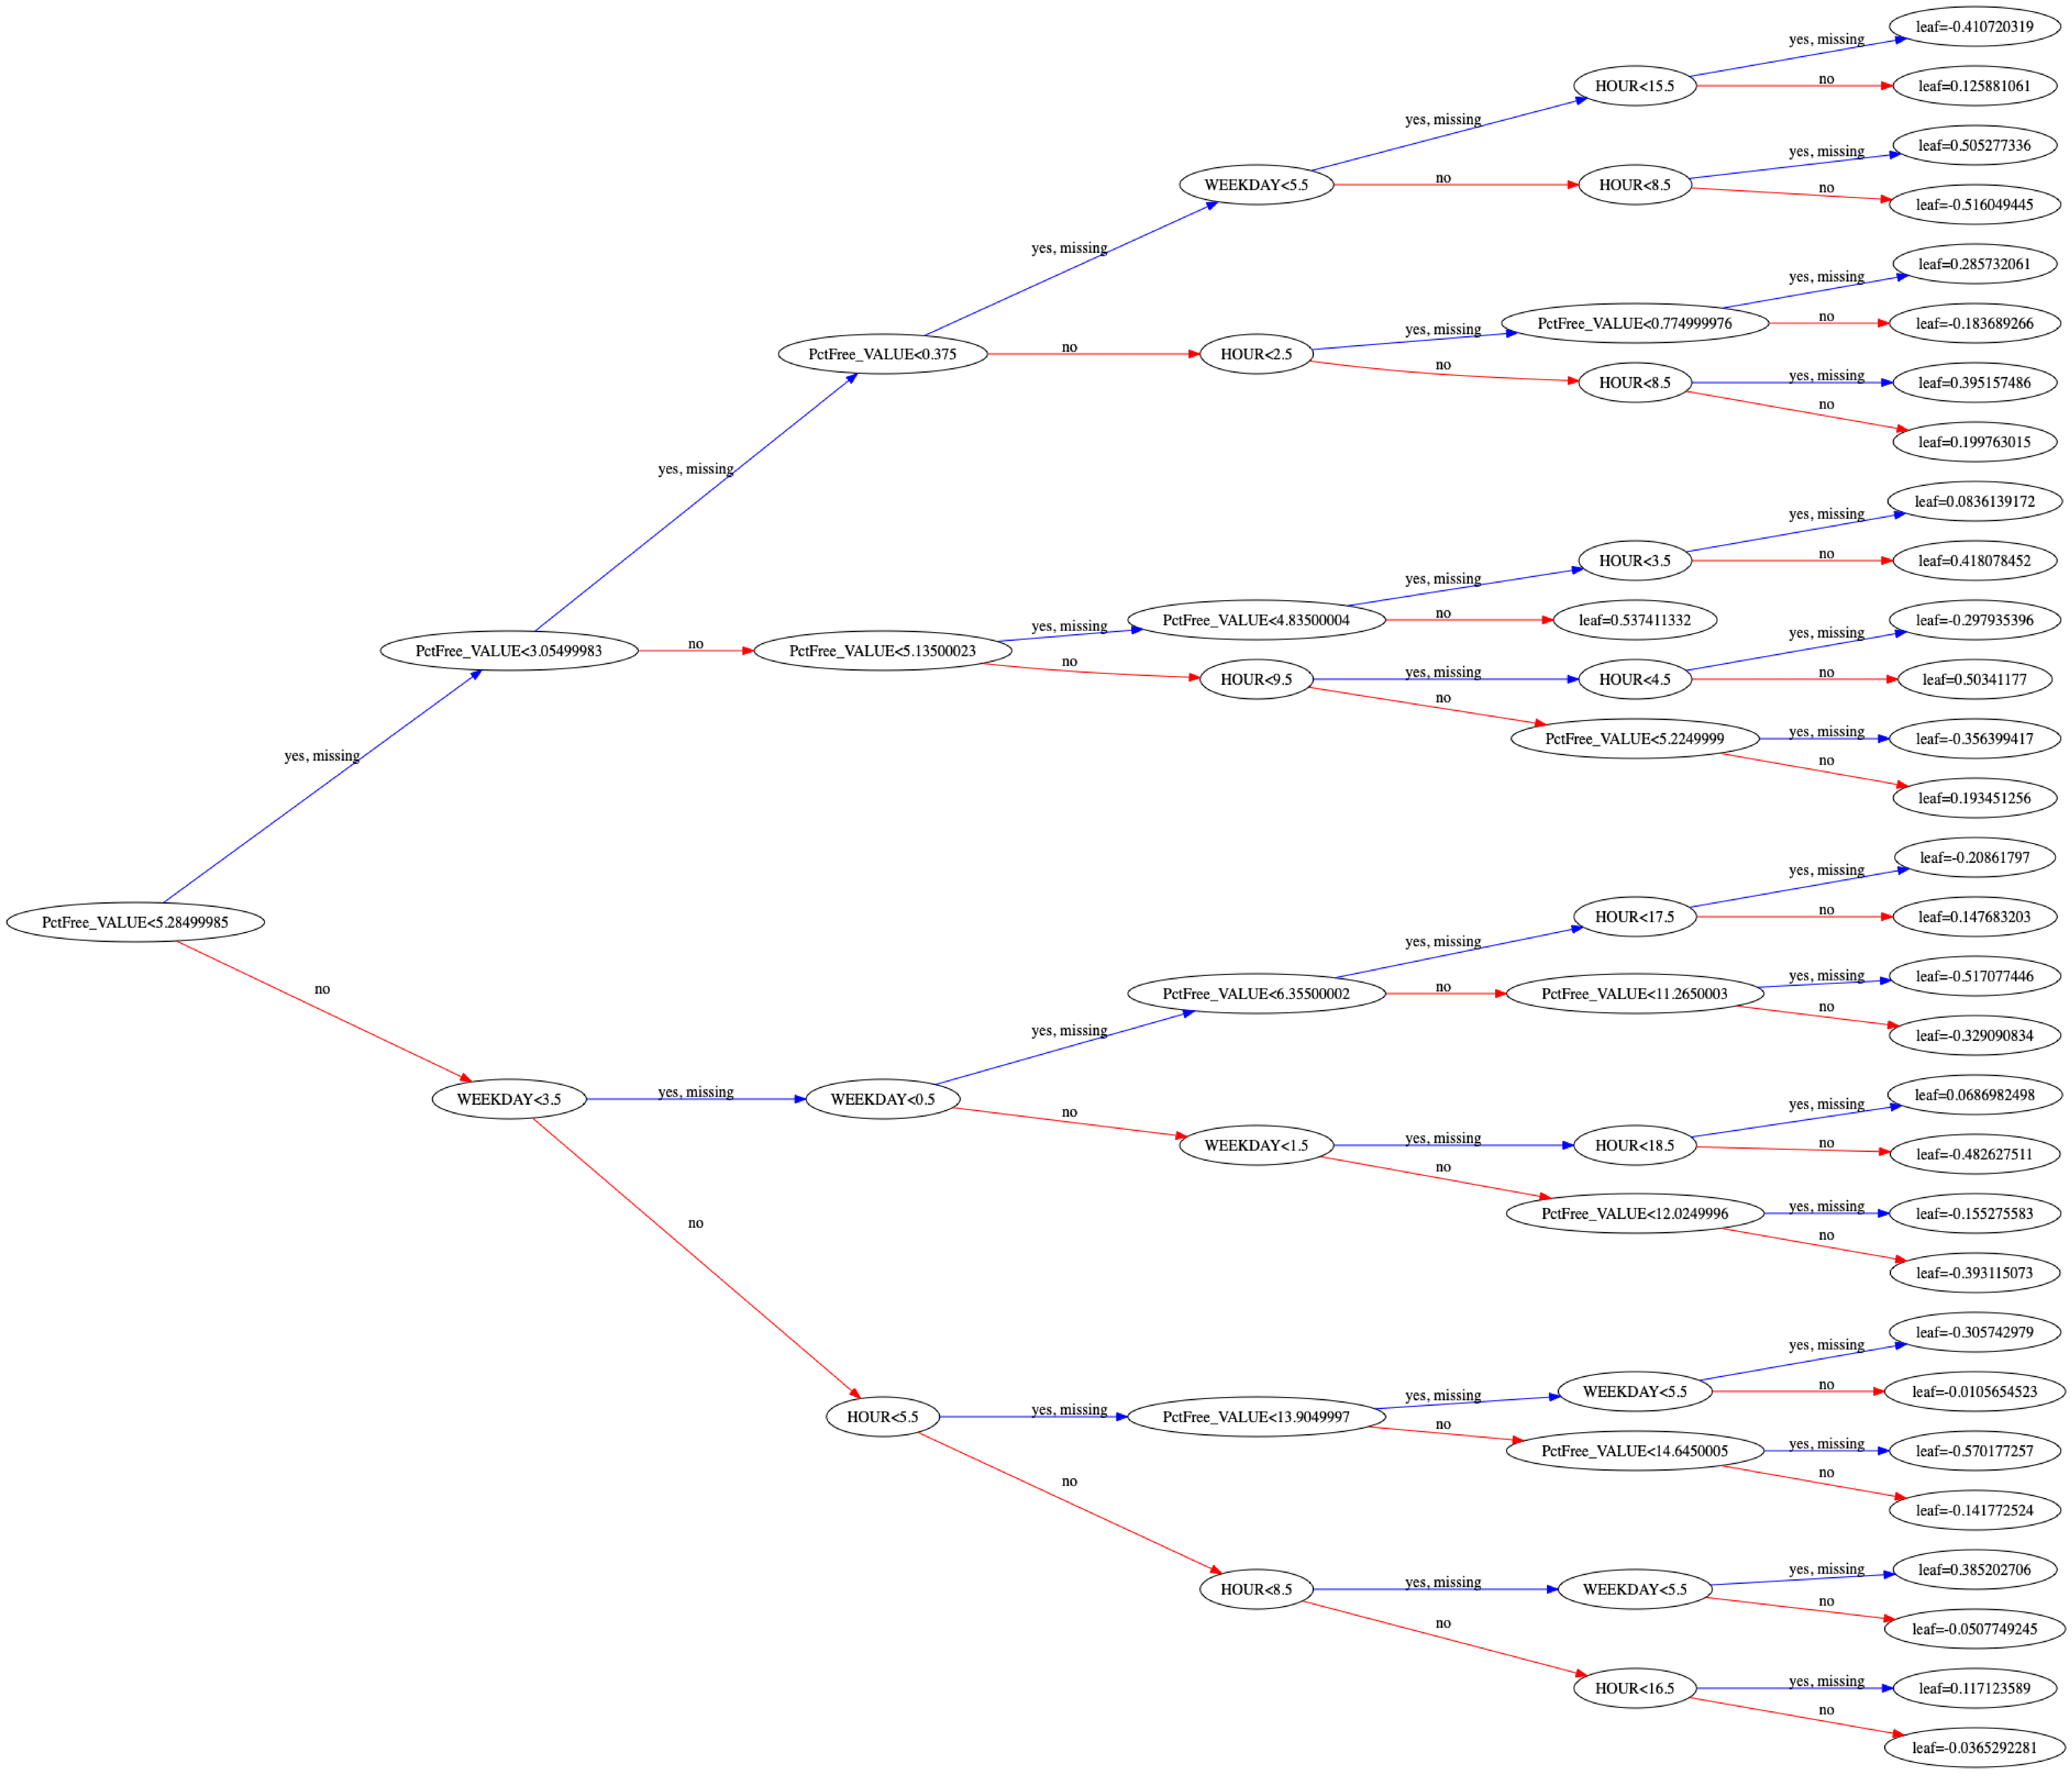

In [42]:
# ! pip3 install graphviz -U
from xgboost import plot_tree
plot_tree(optimized_GBM, rankdir='LR')
fig = plt.gcf()
fig.set_size_inches(150, 100)
fig.savefig('tree.png')

In [41]:
from sklearn.datasets import load_iris
from xgboost import XGBClassifier

optimized_GBM.get_booster().dump_model('xgb_model.txt', with_stats=True)
with open('xgb_model.txt', 'r') as f:
    txt_model = f.read()
print(txt_model)

booster[0]:
0:[PctFree_VALUE<5.28499985] yes=1,no=2,missing=1,gain=158951.141,cover=767652
	1:[PctFree_VALUE<3.05499983] yes=3,no=4,missing=3,gain=13101.3125,cover=99372.9922
		3:[PctFree_VALUE<0.375] yes=7,no=8,missing=7,gain=3446.83008,cover=41780.2695
			7:[WEEKDAY<6] yes=15,no=16,missing=15,gain=5353.63672,cover=8312.80566
				15:[HOUR<16] yes=31,no=32,missing=31,gain=4342.07373,cover=5321.58057
					31:leaf=-0.410720319,cover=2583.39453
					32:leaf=0.125881061,cover=2738.18604
				16:[HOUR<9] yes=33,no=34,missing=33,gain=3959.20557,cover=2991.2251
					33:leaf=0.505277336,cover=2627.7251
					34:leaf=-0.516049445,cover=363.5
			8:[HOUR<3] yes=17,no=18,missing=17,gain=2051.60547,cover=33467.4648
				17:[PctFree_VALUE<0.774999976] yes=35,no=36,missing=35,gain=1244.46069,cover=2188.50464
					35:leaf=0.285732061,cover=794.181274
					36:leaf=-0.183689266,cover=1394.32349
				18:[HOUR<9] yes=37,no=38,missing=37,gain=3083.48438,cover=31278.959
					37:leaf=0.395157486,cover=13885.7656